# 8.5


# LDA


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
data=np.load("./data/spam-data-hw3.npz")
data.keys()

KeysView(NpzFile './data/spam-data-hw3.npz' with keys: training_data, training_labels, test_data)

In [3]:
training_data=data['training_data']
training_label=data['training_labels']


In [4]:
def compute_lda_parameters(X_train,y_train,regularization=1e-3):
    n_classes=len(np.unique(y_train))
    n_features=X_train.shape[1]

    means=np.zeros((n_classes,n_features))
    for c in range(n_classes):
        class_mask=(y_train==c)
        means[c]=np.mean(X_train[class_mask],axis=0)

    pooled_cov=np.zeros((n_features,n_features))
    total_samples=len(X_train)

    for c in range(n_classes):
        class_mask=(y_train==c)
        class_data=X_train[class_mask]
        n_class_samples=len(class_data)

        if n_class_samples>1:
            centered_data=class_data-means[c]
            class_cov=np.dot(centered_data.T,centered_data)/(n_class_samples-1)

            pooled_cov+=(n_class_samples/total_samples)*class_cov

    pooled_cov+=regularization*np.eye(n_features)

    return means,pooled_cov

In [5]:
def lda_predict(X,means,pooled_cov,prior_probs):
    n_samples,n_features=X.shape
    n_classes=len(means)

    try:
        inv_cov=np.linalg.inv(pooled_cov)
    except np.linalg.LinAlgError:
        reg_cov=pooled_cov+1e-6*np.eye(n_features)
        inv_cov=np.linalg.inv(reg_cov)

    log_posterior=np.zeros((n_samples,n_classes))

    for c in range(n_classes):
        linear_term=np.dot(X,np.dot(inv_cov,means[c]))
        constant_term=-0.5*np.dot(means[c],np.dot(inv_cov,means[c]))
        log_posterior[:,c]=linear_term+constant_term+np.log(prior_probs[c])


    return np.argmax(log_posterior,axis=1)



In [6]:
def split_data(X,y,test_size=10000,random_state=42):
    np.random.seed(random_state)
    n_samples=len(X)
    indices=np.random.permutation(n_samples)

    train_indices=indices[test_size:]
    val_indices=indices[:test_size]

    return X[train_indices],X[val_indices],y[train_indices],y[val_indices]

In [7]:
def experiment_lda_sizes(X_train, y_train, X_val, y_val):
    sizes = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
    error_rates = []

    for size in sizes:
        if size>len(X_train):
            continue

        indices=np.random.choice(len(X_train),size=size,replace=False)
        X_subset=X_train[indices]
        y_subset=y_train[indices]

        means,pooled_cov=compute_lda_parameters(X_subset,y_subset)
        prior_probs=np.bincount(y_subset)/len(y_subset)
        
        predictions=lda_predict(X_val,means,pooled_cov,prior_probs)

        error_rate=1-np.mean(predictions==y_val)
        error_rates.append(error_rate)

        print(f"Size: {size}, Error Rate: {error_rate:.4f}")

    
    return sizes[:len(error_rates)],error_rates

In [8]:
def plot_error_rates(sizes,error_rates):
    plt.figure(figsize=(10,6))
    plt.plot(sizes,error_rates,'bo-',linewidth=2,markersize=8)

    plt.xlabel('Training Set Size')
    plt.ylabel('Error Rate')
    plt.title('LDA Error Rate vs Training Set Size')
    plt.grid(True,alpha=0.3)
    plt.show()

    



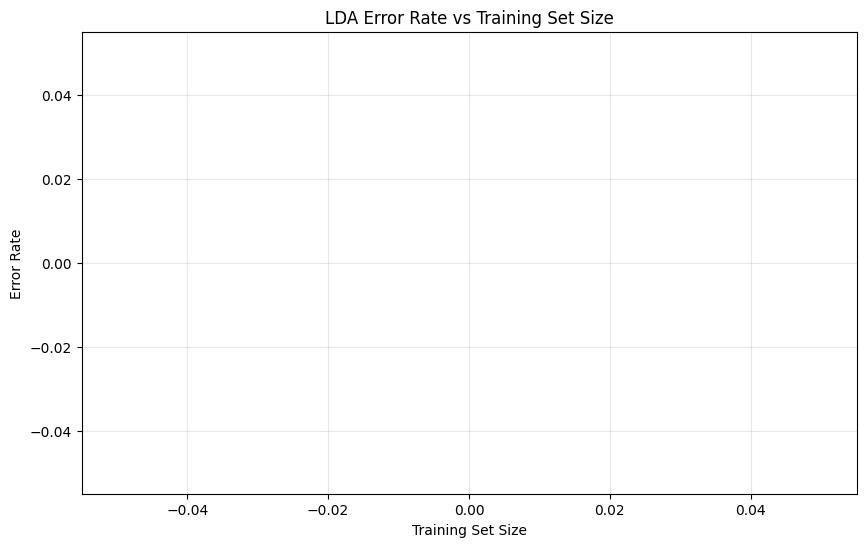

In [9]:
np.random.seed(42)
X_train,X_val,y_train,y_val=split_data(training_data,training_label,test_size=5000)

sizes,error_rates=experiment_lda_sizes(X_train,y_train,X_val,y_val)
# 运行一次调试版本

plot_error_rates(sizes,error_rates)



# QDA

In [10]:
data=np.load("./data/spam-data-hw3.npz")
data.keys()

KeysView(NpzFile './data/spam-data-hw3.npz' with keys: training_data, training_labels, test_data)

In [11]:
training_data=data['training_data']
training_label=data['training_labels']


In [12]:
def compute_qda_parameters(X_train,y_train,regularization=1e-3):
    n_classes=len(np.unique(y_train))
    n_features=X_train.shape[1]

    means=np.zeros((n_classes,n_features))
    covs=np.zeros((n_classes,n_features,n_features))
    
    for c in range(n_classes):
        class_mask=(y_train==c)
        class_data=X_train[class_mask]
        n_class_samples=len(class_data)

        means[c]=np.mean(class_data,axis=0)

        if n_class_samples>1:
            centered_data=class_data-means[c]
            class_cov=np.dot(centered_data.T,centered_data)/(n_class_samples-1)
            covs[c]=class_cov+regularization*np.eye(n_features)

        else:
            covs[c]=regularization*np.eye(n_features)

    return means,covs
            

In [13]:
def qda_predict(X,means,covs,prior_probs):
    n_samples,n_features=X.shape
    n_classes=len(means)

    log_posterior=np.zeros((n_samples,n_classes))
    
    for c in range(n_classes):
        try:
            inv_cov=np.linalg.inv(covs[c])
            sign,logdet_cov=np.linalg.slogdet(covs[c])

        except np.linalg.LinAlgError:
            reg_cov=covs[c]+1e-6*np.eye(n_features)
            inv_cov=np.linalg.inv(reg_cov)
            sign,logdet_cov=np.linalg.slogdet(reg_cov)

        diff=X-means[c]
        quadratic=-0.5*np.sum(np.dot(diff,inv_cov)*diff,axis=1)
        logdet_term=-0.5*logdet_cov
        constant_term=-0.5*n_features*np.log(2*np.pi)
        prior_term=np.log(prior_probs[c])

        log_posterior[:,c]=quadratic+logdet_term+constant_term+prior_term

    return np.argmax(log_posterior,axis=1)

    


In [14]:
def experiment_qda_sizes(X_train, y_train, X_val, y_val):
    sizes = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
    error_rates = []
    
    for size in sizes:
        if size > len(X_train):
            continue
            
        indices = np.random.choice(len(X_train), size=size, replace=False)
        X_subset = X_train[indices]
        y_subset = y_train[indices]
        
        means, covariances = compute_qda_parameters(X_subset, y_subset)
        prior_probs = np.bincount(y_subset, minlength=10) / len(y_subset)
        
        predictions = qda_predict(X_val, means, covariances, prior_probs)
        
        error_rate = 1 - np.mean(predictions == y_val)
        error_rates.append(error_rate)
        
        print(f"QDA Size: {size}, Error Rate: {error_rate:.4f}")
    
    return sizes[:len(error_rates)], error_rates

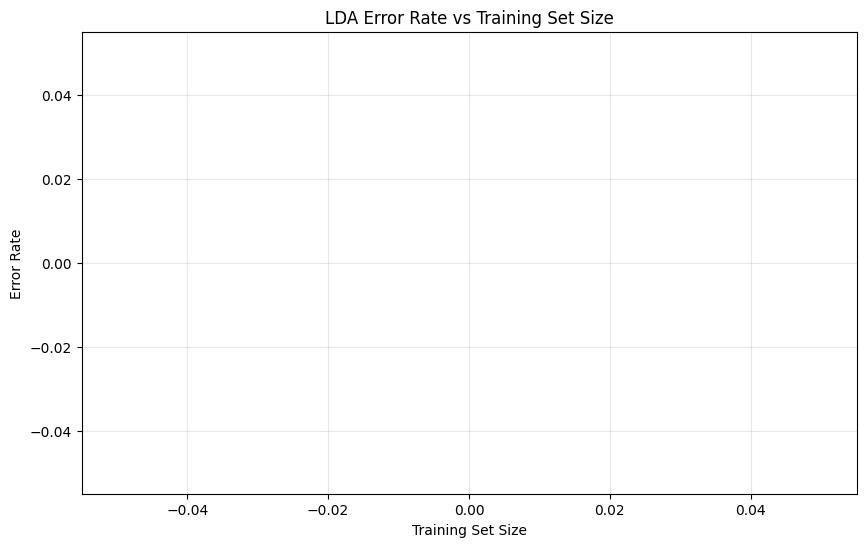

In [15]:
np.random.seed(42)
X_train,X_val,y_train,y_val=split_data(training_data,training_label,test_size=5000)

sizes,error_rates=experiment_qda_sizes(X_train,y_train,X_val,y_val)
# 运行一次调试版本

plot_error_rates(sizes,error_rates)



# TEST RUN

In [16]:
spam_test_data=data['test_data']
spam_test_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(1000, 32))

In [17]:
lda_means, lda_cov_matrix = compute_lda_parameters(training_data, training_label)
lda_prior_probs = np.bincount(training_label, minlength=10) / len(training_label)

qda_means, qda_covs = compute_qda_parameters(training_data, training_label)
qda_priors = np.bincount(training_label, minlength=10) / len(training_label)

In [18]:
print("Making LDA predictions...")
lda_predictions = lda_predict(spam_test_data, lda_means, lda_cov_matrix, lda_prior_probs)

print("Making QDA predictions...")
qda_predictions = qda_predict(spam_test_data, qda_means, qda_covs, qda_priors)




Making LDA predictions...
Making QDA predictions...


In [19]:
lda_predictions

array([0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,

In [20]:
qda_predictions

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,